# Plan



Generate some low dimensional dynamics
Then add space on top of that




In [1]:
#%matplotlib notebook
%matplotlib inline

import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.optimize as op
from functools import partial
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
from jax import grad
seaborn.set(font_scale=1.5,style='ticks')

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append("/Users/yves/Documents/Code/mec_ephys/packages/")

In [3]:
from mecll import dynamics
from mecll.dynamics import predict_all, get_basis_tensor, grad_wrapper, caley_transform, get_spatial_tuning

In [4]:
#np.random.seed(99)
x1,x2,A = dynamics.simulate_dynamics(dim=5,frac_noise_dynamics=1.)

#np.random.seed(99)
sim_res = dynamics.simulate_activity(n_neurons=120,x=x1,x_2=x2)
act_matrix, act_matrix2, space_order2, space_order2_inv = sim_res

ValueError: too many values to unpack (expected 4)

In [ ]:
act_matrix2 = act_matrix2[space_order2_inv]

In [ ]:
n_neurons = act_matrix.shape[1]

In [ ]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# Run with jax

In [12]:
REMOVE_SPACE = False

In [13]:
if REMOVE_SPACE:
    spatial_response = (act_matrix + act_matrix2[space_order2_inv])/2.
    act_matrix2 = act_matrix2 - spatial_response[space_order2]
    act_matrix = act_matrix - spatial_response

In [14]:
#grad_predict_all = grad(predict_all)

In [15]:
from sklearn.decomposition import PCA

In [17]:
pca_dim = 5
pca = PCA(n_components=pca_dim)


pca.fit(np.vstack([act_matrix,act_matrix2]))
pca_activity = pca.transform(act_matrix)
pca_activity2 = pca.transform(act_matrix2)

In [18]:
n_params = int(pca_dim*(pca_dim-1)/2)
basis_tensor_inf = get_basis_tensor(pca_dim)

params = np.random.normal(size=(n_params))# + np.eye(dim)
res = op.minimize(predict_all,
           params,
           (pca_activity,pca_dim,basis_tensor_inf),
           jac=grad_wrapper,
           method='BFGS'
           )
print(res.message)

Desired error not necessarily achieved due to precision loss.


In [19]:
o = np.random.permutation(np.arange(9))
np.allclose(act_matrix[o][:,1],act_matrix[:,1][o])

True

In [20]:
print(res.fun,res.message)

10.171995 Desired error not necessarily achieved due to precision loss.


In [21]:
out = res.x
#out = np.random.normal(size=(n_params))# + np.eye(dim)

skewM = np.einsum('i...,i...',out,basis_tensor_inf)
Ainf = caley_transform(skewM,pca_dim)

In [22]:
predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity.T).T)

In [23]:
#predicted_neural_activity = pca.inverse_transform(pca_activity)

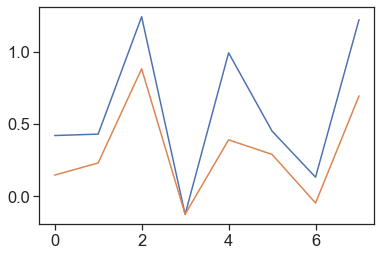

In [24]:
ix_ = 0
plt.plot(predicted_neural_activity[:,ix_][:-1])
plt.plot(act_matrix[:,ix_][1:])

In [25]:
cc = []
for i in range(n_neurons):
    cc.append(np.corrcoef(act_matrix[:,i][1:],predicted_neural_activity[:,i][:-1])[0,1])
    
print(np.mean(cc))

0.9379751526213645


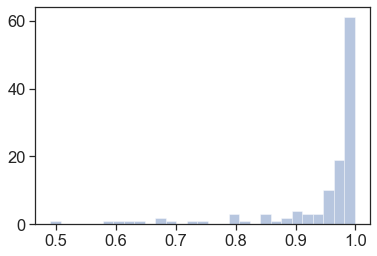

In [26]:
seaborn.distplot(cc,kde=0)

## Now look at the held out task

In [27]:

skewM = np.einsum('i...,i...',out,basis_tensor_inf)
Ainf = caley_transform(skewM,pca_dim)

In [28]:
predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity2.T).T)

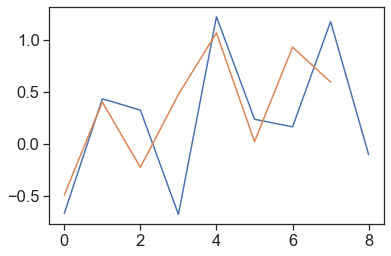

In [29]:
ix_ = 0
plt.plot(predicted_neural_activity[:,ix_])
plt.plot(act_matrix2[:,ix_][1:])

In [30]:
cc = []
for i in range(n_neurons):
    cc.append(np.corrcoef(act_matrix2[:,i][1:],predicted_neural_activity[:,i][:-1])[0,1])
print(np.mean(cc))

0.8208241708612033


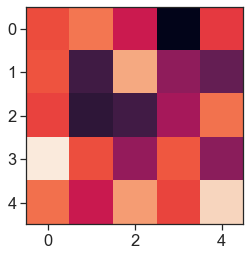

In [31]:
plt.imshow(A)

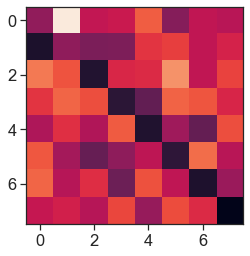

In [28]:
plt.imshow(Ainf)

# Now run actual clean test

In [5]:
def evaluate_cc(activity,pred):
    n_neurons = activity.shape[1]
    true_cc = []
    #print(activity[:,0])

    for i in range(n_neurons):
        true_cc.append(np.corrcoef(activity[:,i][1:],pred[:,i][:-1])[0,1])

    true_cc = np.nanmean(true_cc)
    return np.nanmean(true_cc)

In [6]:
def fit_data(neural_activity1,neural_activity2,pca_activity1,pca_activity2,pca,NFITS=5,NSHUFF=2000):
    pca_dim = pca_activity.shape[1]
    fit_params = []
    fit_quality = []
    for _ in range(NFITS):
        n_params = int(pca_dim*(pca_dim-1)/2)
        basis_tensor_inf = get_basis_tensor(pca_dim)

        params = np.random.normal(size=(n_params))# + np.eye(dim)
        res = op.minimize(predict_all,
                   params,
                   (pca_activity1,pca_dim,basis_tensor_inf),
                   jac=grad_wrapper,
                   method='BFGS'
                   )
        out = res.x
        #out = np.random.normal(size=(n_params))# + np.eye(dim)

        skewM = np.einsum('i...,i...',out,basis_tensor_inf)
        Ainf = caley_transform(skewM,pca_dim)
        #print(res.message)

        predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity1.T).T)
        fit_params.append(out.copy())
        fit_quality.append(evaluate_cc(neural_activity1,predicted_neural_activity))
    params = fit_params[np.argmax(fit_quality)]
    print(fit_quality)
    
    predicted_neural_activity2 = pca.inverse_transform((Ainf@pca_activity2.T).T)
    res = evaluate_cc(neural_activity2,predicted_neural_activity2)
    shuffle_res = []
    print(res)
    
    r9 = np.arange(9)

    for _ in range(NSHUFF):
        
        perm_order = np.random.permutation(r9)
        predicted_neural_activity2_shuff = pca.inverse_transform((Ainf@pca_activity2[perm_order].T).T)

        shf_res = evaluate_cc(neural_activity2[perm_order],predicted_neural_activity2_shuff)
        shuffle_res.append(shf_res)
    return res, shuffle_res
    

In [28]:
#np.random.seed(99)
x1,x2,A = dynamics.simulate_dynamics(dim=5,frac_noise_dynamics=1.,)

#np.random.seed(99)
sim_res = dynamics.simulate_activity(n_neurons=120,x=x1,x_2=np.random.normal(size=x2.shape),frac_space=1)
act_matrix, act_matrix2, space_order2, space_order2_inv, task_order2, task_order2_inv = sim_res
act_matrix2 = act_matrix2[task_order2_inv]

In [29]:
pca_dim = 5
pca = PCA(n_components=pca_dim)


pca.fit(np.vstack([act_matrix,act_matrix2]))
pca_activity = pca.transform(act_matrix)
pca_activity2 = pca.transform(act_matrix2)

In [30]:
res = fit_data(act_matrix,act_matrix2,pca_activity,pca_activity2,pca,NFITS=1,NSHUFF=100)

[0.540718795747299]
0.4616101399792188


In [22]:
real_res = res[0]
shuffle_res = res[1]

In [23]:
real_res

0.13473831840944359

In [24]:
np.mean(shuffle_res)

0.06713511343808283

In [56]:
mean_real_pred_accuracy = real_res

In [57]:
np.percentile(shuffle_res,97.5)

0.3872847082690467

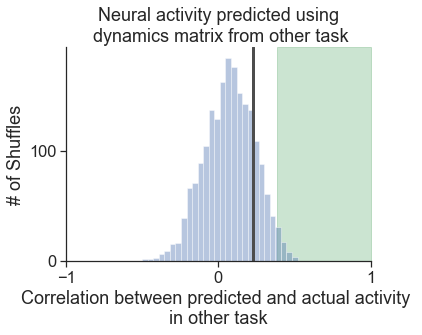

In [58]:
plt.figure(figsize=(6,5))
plt.title("Neural activity predicted using\n dynamics matrix from other task")
seaborn.distplot(shuffle_res,kde=0)
plt.axvline(x=real_res,color='.3',linewidth=3)
#plt.annota
seaborn.despine()
plt.xlim(-1,1)
yl = plt.gca().get_ylim()
plt.fill_between([np.percentile(shuffle_res,97.5),1],[yl[1]]*2,color='g',alpha=.3)
plt.ylim(yl)
plt.xlabel("Correlation between predicted and actual activity \nin other task")
plt.ylabel("# of Shuffles")
plt.locator_params(nbins=3)
plt.tight_layout()